### CMP637-GenAI Assignment-phase2 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### Jan 2026

In [13]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
from tqdm import tqdm #.notebook as tqdm
import wandb

## Define utility functions
> I only added flattening to the data transformations

In [14]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

 ## Load and visualize the dataset
 I added image Flattening

In [15]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

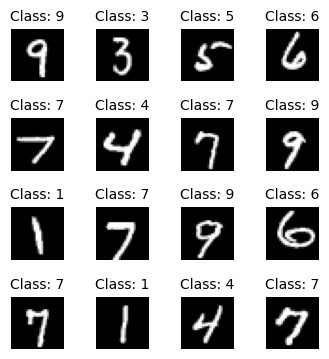

In [16]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

## Define the model

In [32]:
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, num_classes, mask):
        super().__init__()
        self.register_buffer("mask", mask)

        # conditioner network (takes x_masked + y_onehot)
        self.net = nn.Sequential(
            nn.Linear(dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim * 2),   # outputs scale + shift
        )

    def forward(self, x, y):
        # mask out part of x
        x_masked = x * self.mask

        # concat conditioning
        h = torch.cat([x_masked, y], dim=1)
        s, t = self.net(h).chunk(2, dim=1)

        # stabilize scale
        s = torch.tanh(s)

        # affine transform on unmasked part
        z = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)

        # log-det Jacobian
        log_det = ((1 - self.mask) * s).sum(dim=1)

        return z, log_det

    def inverse(self, z, y):
        z_masked = z * self.mask

        h = torch.cat([z_masked, y], dim=1)
        s, t = self.net(h).chunk(2, dim=1)
        s = torch.tanh(s)

        x = z_masked + (1 - self.mask) * ((z - t) * torch.exp(-s))

        return x
class ConditionalFlow(nn.Module):
    def __init__(self, dim=28*28, num_classes=10, hidden_dim=512, n_layers=12):
        super().__init__()

        self.dim = dim
        self.num_classes = num_classes

        masks = []
        
        # alternate masks (checkerboard-like, but vector)
        for i in range(n_layers):
            if i % 2 == 0:
                mask = torch.cat([torch.ones(dim // 2), torch.zeros(dim - dim // 2)])
            else:
                mask = torch.cat([torch.zeros(dim // 2), torch.ones(dim - dim // 2)])
            masks.append(mask)

        self.layers = nn.ModuleList([
            AffineCoupling(dim, hidden_dim, num_classes, mask)
            for mask in masks
        ])

    def forward(self, x, y):
        """
        Forward: x -> z, compute log-likelihood terms
        """
        log_det_sum = 0.0
        z = x

        for layer in self.layers:
            z, log_det = layer(z, y)
            log_det_sum += log_det

        return z, log_det_sum

    @torch.no_grad()
    def sample(self, y):
        """
        Sample: z ~ N(0, I) -> x
        """
        device = y.device
        n_samples = y.size(0)
        z = torch.randn(n_samples, self.dim, device=device)

        x = z
        for layer in reversed(self.layers):
            x = layer.inverse(x, y)

        # clamp to [0,1] after inversion
        return torch.clamp(x, 0.0, 1.0)


In [33]:
def flow_loss(z, log_det):
    # log p(z) under standard normal
    log_pz = -0.5 * (z.pow(2) + math.log(2 * math.pi)).sum(dim=1)

    # maximize log p(x) == minimize negative
    log_px = log_pz + log_det

    return -log_px.mean()


# Instantiate model and optim
# Trainig

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConditionalFlow().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

epochs = 15
loss_history = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):

        x = x.to(device).view(x.size(0), -1)
        # y = y.to(device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(device)

        optimizer.zero_grad()

        z, log_det = model(x, y_onehot)
        loss = flow_loss(z, log_det)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(train_loader):.4f}")
    loss_history.append(total_loss / len(train_loader))


Epoch 0/15: 100%|██████████| 938/938 [00:18<00:00, 50.51it/s]


Epoch [1/15] Loss: -1409.2397


Epoch 1/15: 100%|██████████| 938/938 [00:18<00:00, 50.21it/s]


Epoch [2/15] Loss: -1689.8615


Epoch 2/15: 100%|██████████| 938/938 [00:18<00:00, 50.01it/s]


Epoch [3/15] Loss: -1764.4461


Epoch 3/15: 100%|██████████| 938/938 [00:18<00:00, 50.30it/s]


Epoch [4/15] Loss: -1811.6093


Epoch 4/15: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s]


Epoch [5/15] Loss: -1837.8647


Epoch 5/15: 100%|██████████| 938/938 [00:18<00:00, 50.41it/s]


Epoch [6/15] Loss: -1856.0594


Epoch 6/15: 100%|██████████| 938/938 [00:18<00:00, 50.48it/s]


Epoch [7/15] Loss: -1874.2835


Epoch 7/15: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]


Epoch [8/15] Loss: -1887.1571


Epoch 8/15: 100%|██████████| 938/938 [00:18<00:00, 50.14it/s]


Epoch [9/15] Loss: -1890.7822


Epoch 9/15: 100%|██████████| 938/938 [00:18<00:00, 50.12it/s]


Epoch [10/15] Loss: -1907.9294


Epoch 10/15: 100%|██████████| 938/938 [00:18<00:00, 50.59it/s]


Epoch [11/15] Loss: -1912.1142


Epoch 11/15: 100%|██████████| 938/938 [00:18<00:00, 50.52it/s]


Epoch [12/15] Loss: -1918.5683


Epoch 12/15: 100%|██████████| 938/938 [00:18<00:00, 50.63it/s]


Epoch [13/15] Loss: -1926.0349


Epoch 13/15: 100%|██████████| 938/938 [00:18<00:00, 50.49it/s]


Epoch [14/15] Loss: -1928.7620


Epoch 14/15: 100%|██████████| 938/938 [00:18<00:00, 50.38it/s]

Epoch [15/15] Loss: -1934.5350


# Plot the loss function
for more detailed report visit my wandb report here to show all the loss and training experiments.

Well, not all, but the last working ones :-D

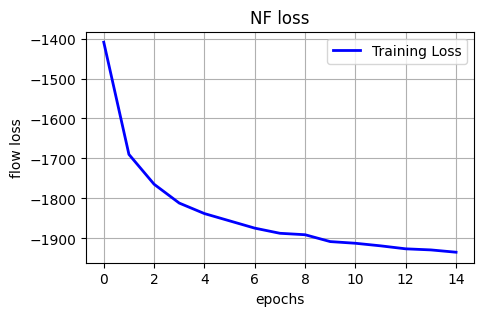

In [35]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

plt.title('NF loss')
plt.xlabel('epochs')
plt.ylabel('flow loss')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [21]:
# ## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "made_temp.pth")

# loaded_model = ContinuousConditionalMADE(
#     input_size=input_dim,
#     cond_size=10,
#     hidden_sizes=hidden_dim,
# )
# # loaded_model = ConditionalMADE(input_size=input_dim,
# #                         cond_size=10,
# #                         hidden_sizes=hidden_dim,
# #                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_temp.pth"))

## Generate some images and display them

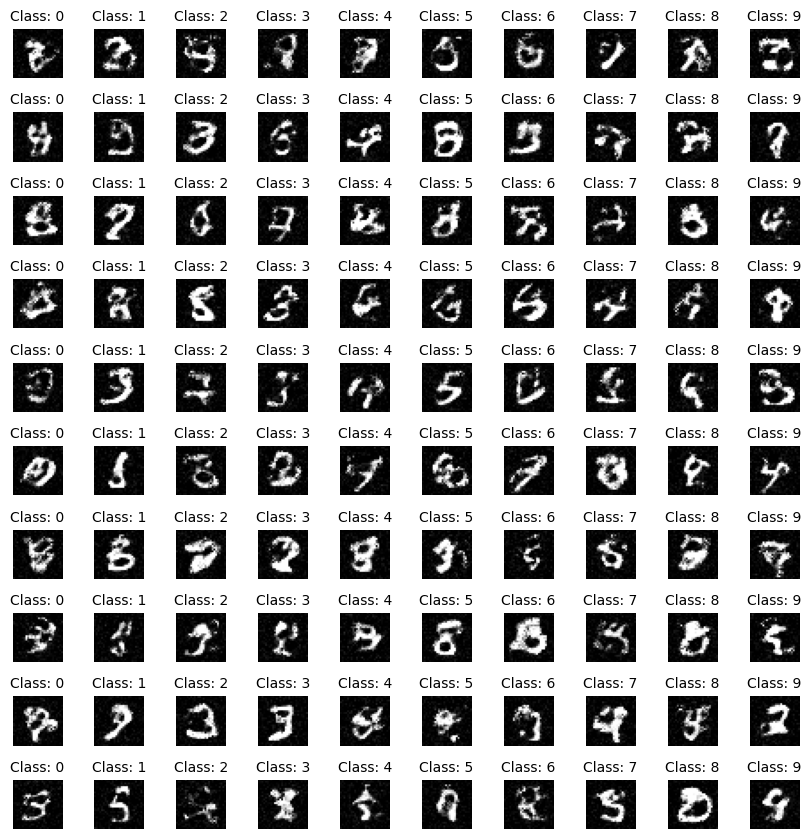

In [22]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval() # put model in evaluation mode
    new_x = model.sample(y_cond)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

# Extra: visualization

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


@torch.no_grad()
def interpolate_grid(model, steps=10):
    """
    Returns a tensor of shape [10, steps, 1, 28, 28]
    rows = digits 0..9
    cols = latent interpolations
    """
    model.eval()
    device = next(model.parameters()).device
    dim = model.dim

    grid = []

    for digit in range(10):

        # fixed label (conditioning)
        y = torch.tensor([digit], device=device)
        y_onehot = F.one_hot(y, num_classes=10).float()

        # pick two random latent points
        z1 = torch.randn(1, dim, device=device)
        z2 = torch.randn(1, dim, device=device)

        alphas = torch.linspace(0, 1, steps, device=device)

        row_imgs = []

        for a in alphas:
            z = (1 - a) * z1 + a * z2

            x = z
            for layer in reversed(model.layers):
                x = layer.inverse(x, y_onehot)

            x = torch.clamp(x, 0, 1)
            row_imgs.append(x.view(1, 1, 28, 28))

        row_imgs = torch.cat(row_imgs, dim=0)
        grid.append(row_imgs)

    return torch.stack(grid)     # [10, steps, 1, 28, 28]


In [30]:
def show_interpolation_grid(model, steps=10):
    imgs = interpolate_grid(model, steps=steps)   # [10, steps, 1, 28, 28]

    fig, axes = plt.subplots(10, steps, figsize=(steps, 10))

    for i in range(10):
        for j in range(steps):
            axes[i, j].imshow(imgs[i, j, 0].cpu(), cmap="gray")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


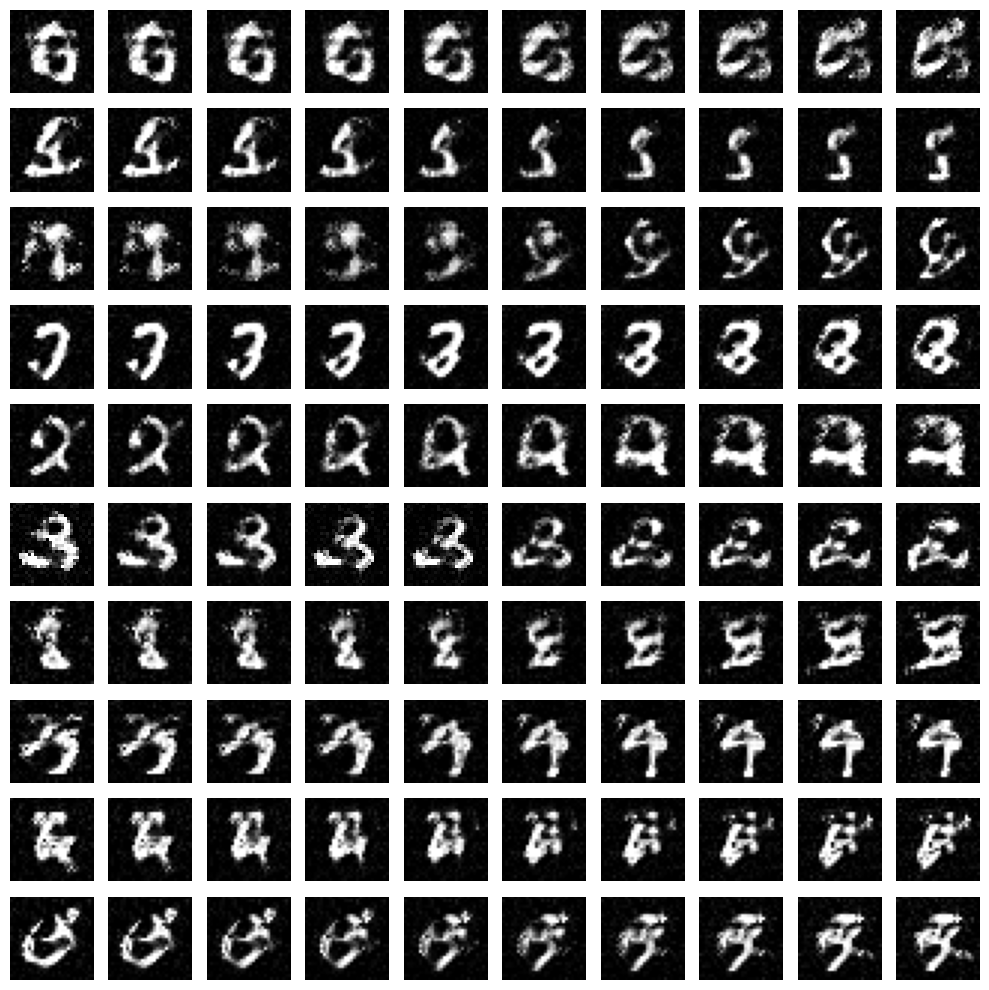

In [31]:
# show_images(imgs,ya)
show_interpolation_grid(model, steps=10)

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).